# KMeans outlier detection model
Outlier detection model using KMeans to cluster the dataset and an upper quantile threshold to find records that are far from their cluster centers.

In [0]:
import pandas as pd
import math

import json

# Matplotlib for visualization at the end
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, when, lit, udf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

### Data load from DBFS store

In [0]:
# Load selected features
feature_cols_json = dbutils.fs.head("dbfs:/tmp/feature_cols.json")
feature_cols = json.loads(feature_cols_json)
feature_cols

Out[2]: ['temperature_2m',
 'precipitation',
 'wind_speed_10m',
 'wind_speed_80m',
 'wind_speed_120m',
 'wind_speed_180m',
 'cloud_cover']

In [0]:
# Load data from DBFS
sdf = spark.table("historical_weather_hourly_lisbon")
display(sdf.limit(10))

time,temperature_2m,precipitation,wind_speed_10m,wind_speed_80m,wind_speed_120m,wind_speed_180m,cloud_cover,features,features_scaled
2025-03-17T06:00,11.6,0.1,2.9,13.6,17.7,18.8,83.0,"Map(vectorType -> dense, length -> 7, values -> List(11.6, 0.1, 2.9, 13.6, 17.7, 18.8, 83.0))","Map(vectorType -> dense, length -> 7, values -> List(-1.1228764848286579, 0.1032961123950345, -1.2036797775546113, -0.5039747038691812, -0.34803538323174504, -0.4649301367103813, 0.7526122039966409))"
2025-03-17T07:00,11.9,0.0,4.0,15.0,18.9,22.1,79.0,"Map(vectorType -> dense, length -> 7, values -> List(11.9, 0.0, 4.0, 15.0, 18.9, 22.1, 79.0))","Map(vectorType -> dense, length -> 7, values -> List(-1.0648974953189316, -0.19775002273369255, -0.9954240734305925, -0.35659793870921425, -0.2359272234209309, -0.19195234315693313, 0.649717708688776))"
2025-03-17T08:00,12.5,0.0,4.6,13.3,17.8,20.2,80.0,"Map(vectorType -> dense, length -> 7, values -> List(12.5, 0.0, 4.6, 13.3, 17.8, 20.2, 80.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.9489395162994793, -0.19775002273369255, -0.8818300529993094, -0.5355554392606026, -0.33869303658084376, -0.34912137580891855, 0.6754413325157421))"
2025-03-17T09:00,13.9,0.1,9.4,16.2,22.9,27.3,100.0,"Map(vectorType -> dense, length -> 7, values -> List(13.9, 0.1, 9.4, 16.2, 22.9, 27.3, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.6783708985874239, 0.1032961123950345, 0.026922110450955737, -0.23027499714352842, 0.13776664261511654, 0.2381944830485002, 1.189913809055067))"
2025-03-17T10:00,15.0,1.0,12.8,22.5,23.9,25.4,89.0,"Map(vectorType -> dense, length -> 7, values -> List(15.0, 1.0, 12.8, 22.5, 23.9, 25.4, 89.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.46578127038509476, 2.812711328553578, 0.6706215595615601, 0.4329204460763227, 0.23119010912412838, 0.08102545039651474, 0.9069539469584383))"
2025-03-17T11:00,15.3,0.5,15.0,27.4,29.6,31.4,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.3, 0.5, 15.0, 27.4, 29.6, 31.4, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.40780228087536846, 1.3074806529099428, 1.0871329678095982, 0.9487391241362066, 0.7637038682254962, 0.577348711402784, 1.189913809055067))"
2025-03-17T12:00,15.4,0.3,13.8,25.1,27.3,28.7,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.4, 0.3, 13.8, 25.1, 27.3, 28.7, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.3884759510387932, 0.7053883826524885, 0.8599449269470321, 0.7066201528019757, 0.5488298952547689, 0.3540032439499629, 1.189913809055067))"
2025-03-17T13:00,15.4,0.4,12.6,22.4,24.2,26.0,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.4, 0.4, 12.6, 22.4, 24.2, 26.0, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.3884759510387932, 1.0064345177812157, 0.6327568860844656, 0.422393534279182, 0.259217149076832, 0.13065777649714178, 1.189913809055067))"
2025-03-17T14:00,15.2,0.5,11.1,19.8,21.6,23.4,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.2, 0.5, 11.1, 19.8, 21.6, 23.4, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.42712861071194413, 1.3074806529099428, 0.3487718350062578, 0.14869382755352945, 0.01631613615340138, -0.08441563660557502, 1.189913809055067))"
2025-03-17T15:00,15.4,0.4,9.2,16.6,18.3,20.4,100.0,"Map(vectorType -> dense, length -> 7, values -> List(15.4, 0.4, 9.2, 16.6, 18.3, 20.4, 100.0))","Map(vectorType -> dense, length -> 7, values -> List(-0.3884759510387932, 1.0064345177812157, -0.010942563026138838, -0.18816734995496623, -0.2919813033263378, -0.33257726710870966, 1.189913809055067))"


### Utility functions

In [0]:
def train_kmeans_model(df, k, features_col):
    # Trains a k-means model.
    # Inspired by https://spark.apache.org/docs/latest/ml-clustering.html
    kmeans = KMeans().setK(k).setSeed(1)
    kmeans.setFeaturesCol(features_col) # Set custom feature vector col
    model = kmeans.fit(df)
    return model

def compute_distance(point, cluster_id):
    # Function to compute distance between a point and its cluster centroid - "centers" needs to be callable
    center = centers[cluster_id]
    return float(math.sqrt(sum((p - c)**2 for p, c in zip(point, center))))

### Assembly of dataset and preprocessing
Moved to Data Notebook - now only seeing if the data has the correct assembled column

In [0]:
# observe: we have a "features" and "features_scaled" column
sdf

Out[5]: DataFrame[time: string, temperature_2m: double, precipitation: double, wind_speed_10m: double, wind_speed_80m: double, wind_speed_120m: double, wind_speed_180m: double, cloud_cover: double, features: vector, features_scaled: vector]

### K-Means Cluster Count - Discovery/Tuning

In [0]:
# Loop to test different k values and evaluate the models
for k in range(2, 10):
    # Train k means with specific k
    model = train_kmeans_model(sdf, k, "features_scaled")

    # Make predictions
    predictions = model.transform(sdf)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette score:" + str(silhouette) + " for k = " + str(k))

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers (scaled): ")
    for center in centers:
        print(center)

    print("---")

### Optimal Model Training and Saving
Saving model to dbfs for it to be used in streaming notebook


In [0]:
# save best model with k=4 for streaming usage
model = train_kmeans_model(sdf, 4, "features_scaled")
model.write().overwrite().save("/dbfs/tmp/kmeans_model")

### Application on training data and computation of distance threshold
Distance threshold is max distance to a datapoints' cluster center before it's considered an outlier.

In [0]:
# Apply model on training data
predicted_sdf = model.transform(sdf)

# Cluster centers
centers = model.clusterCenters()

# UDF (user defined function) for distance computation
distance_udf = udf(compute_distance, DoubleType()) # Function defined above (Utility Functions) - with double as return value for distance
# Apply distance UDF to all points
scored_sdf = predicted_sdf.withColumn(
    "distance_cluster_center", 
    distance_udf(col("features_scaled"), col("prediction"))
)

# Compute distance threshold for anomalies
distance_threshold = scored_sdf.approxQuantile("distance_cluster_center", [0.95], 0.01)[0] # 0.95 percentile as threshold

# Save threshold as a JSON file
dbutils.fs.put("dbfs:/tmp/kmeans_distance_threshold.json", json.dumps(distance_threshold), overwrite=True)

Wrote 17 bytes.
Out[7]: True

## Application on Historical (training) data and Visualization

### Outlier detection on training data

In [0]:
# Flag highest distances as anomalies
scored_sdf = scored_sdf.withColumn(
    "is_anomaly",
    when(col("distance_cluster_center") > distance_threshold, 1).otherwise(0)
)

scored_sdf.select("features", "features_scaled", "prediction", "distance_cluster_center", "is_anomaly").show(truncate=False) # Check

scored_sdf

+------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------------+----------+
|features                            |features_scaled                                                                                                                                |prediction|distance_cluster_center|is_anomaly|
+------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+----------+-----------------------+----------+
|[11.6,0.1,2.9,13.6,17.7,18.8,83.0]  |[-1.1228764848286579,0.1032961123950345,-1.2036797775546113,-0.5039747038691812,-0.34803538323174504,-0.4649301367103813,0.7526122039966409]   |0         |1.0939139686343846     |0         |
|[11.9,0.0,4.0,15.0,18.9,22.1,79.0]  |[-1.0648974953189316,-0.19775002273369255,-0.9

### Large year-round visualization

In [0]:
# Selection of relevant columns and conversion to pandas for visualization
plot_df = scored_sdf.select(
    "time",
    "temperature_2m",
    "wind_speed_10m",
    "distance_cluster_center",
    "is_anomaly"
).orderBy("time").toPandas()

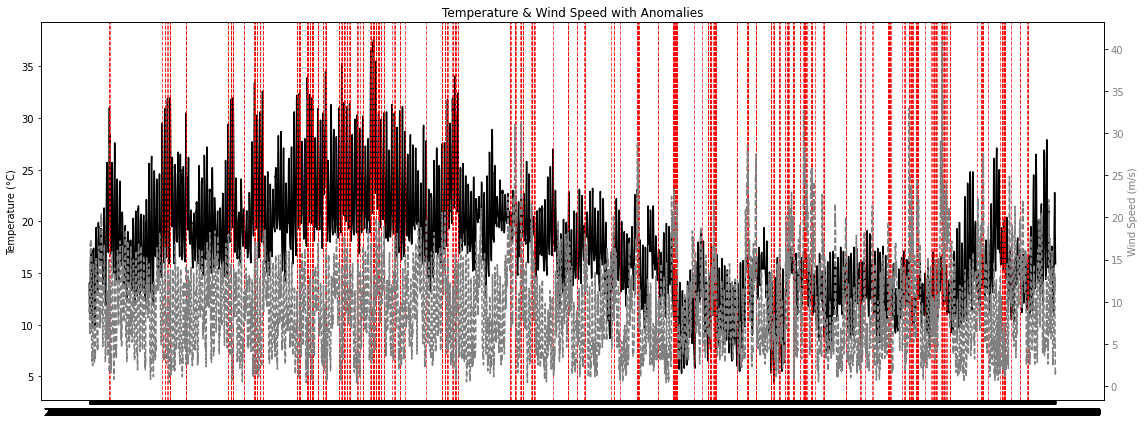

In [0]:
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot temperature as a line
ax1.plot(plot_df["time"], plot_df["temperature_2m"], color="black", label="Temperature (°C)")
ax1.set_ylabel("Temperature (°C)", color="black")
ax1.tick_params(axis='y', labelcolor="black")

# Overlay anomalies
for anomaly_time in plot_df.loc[plot_df["is_anomaly"] == 1, "time"]:
    ax1.axvline(x=anomaly_time, color="red", linestyle="--", linewidth=1, alpha=0.7)

# Secondary axis for wind speed
ax2 = ax1.twinx()
ax2.plot(plot_df["time"], plot_df["wind_speed_10m"], color="gray", linestyle='--', label="Wind Speed (10m)")
ax2.set_ylabel("Wind Speed (m/s)", color="gray")
ax2.tick_params(axis='y', labelcolor="gray")

# Title and legend
plt.title("Temperature & Wind Speed with Anomalies")
fig.tight_layout()
plt.show()